In [1]:
# 1) Imports & seed
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt  

np.random.seed(42)
random.seed(42)

# 2) Game data + helper
payoff = np.array([
    [[2, 2], [3, 0]], 
    [[0, 3], [4, 4]]
])

def get_payoff(player1_strategy, player2_strategy, player_id):
    return payoff[int(player1_strategy), int(player2_strategy), int(player_id)]

a00 = get_payoff(0,0,0); a01 = get_payoff(0,1,0)
a10 = get_payoff(1,0,0); a11 = get_payoff(1,1,0)

def stag_indifference_threshold():
    den = (a00 - a10) + (a11 - a01)
    return float((a00 - a10)/den) if den != 0 else 0.5

# 3) Constants
MEMORY_DISCOUNT = 0.9
TRUST_DISCOUNT  = 0.6
TRUST_SMOOTHING = 0.2
TRUST_MIN = 0.1  
TRUST_MAX = 10.0
EPS = 0.5

In [2]:
class BayesianFocalAgent:
    def __init__(self, alpha0=EPS, beta0=EPS, stochastic=True, inv_temp=2.0):
        # prior mapped from your (x0, T0) for comparability
        if alpha0 <= 0 or beta0 <= 0:
            raise ValueError("alpha0 and beta0 must be > 0")
        self.alpha = float(alpha0)
        self.beta = float(beta0)
        self.stochastic = stochastic  # Fixed: was swapped with inv_temp
        self.inv_temp = float(inv_temp)  

   
    def posterior_mean(self) -> float:
        return self.alpha / (self.alpha + self.beta)

    def make_decision(self) -> int:
        # Fixed: use self.posterior_mean instead of self._posterior_mean()
        p = self.posterior_mean()  # Now using the property correctly
        
        a00 = get_payoff(0,0,0); a01 = get_payoff(0,1,0)
        a10 = get_payoff(1,0,0); a11 = get_payoff(1,1,0)
        EV_hare = (1 - p) * a00 + p * a01
        EV_stag = (1 - p) * a10 + p * a11
        D = EV_stag - EV_hare

        if not self.stochastic:
            return 1 if D > 0 else 0
        # probabilistic (logit) choice:
        prob_stag = 1.0 / (1.0 + np.exp(-self.inv_temp * D))
        return 1 if random.random() < prob_stag else 0

    def update(self, partner_choice: int):
        # partner_choice: 1=cooperate, 0=defect
        if partner_choice not in (0,1):
            raise ValueError("partner_choice must be 0 or 1")
        self.alpha += partner_choice
        self.beta += (1 - partner_choice)

In [3]:
# 5) Partners (belief-driven)
class BeliefDrivenPartnerBase:
    """
    Partner maintains its own beliefs (x_hat in [0,1], t_hat in [t_min,t_max])
    and updates via recency-weighted actions and consistency-based trust.
    """
    def __init__(self, 
                 u_i: float = None, 
                 t0: float = 0.1,
                 eta: float = 0.1, 
                 noise_sigma: float = 0.02, 
                 memory_discount: float = MEMORY_DISCOUNT,
                 trust_discount: float = TRUST_DISCOUNT,
                 trust_smoothing: float = TRUST_SMOOTHING,
                 t_min: float = TRUST_MIN, 
                 t_max: float = TRUST_MAX,
                 # --- asymmetry knobs (mirror focal agent) ---
                 loss_aversion_hat: float = 2.0,      # λ ≥ 1: penalty magnitude for betrayal (expected C, saw D)
                 lambda_surprise_hat: float = 0.5):  # μ (surprise penalty), 0 ≤ μ ≤ λ: penalty weight for expected D, saw C
        if u_i is not None and not 0 <= u_i <= 1:
            raise ValueError("u_i must be between 0 and 1")
        if not t_min <= t0 <= t_max:
            raise ValueError("t0 must be between t_min and t_max")
        if loss_aversion_hat < 1:
            raise ValueError("loss_aversion_hat (λ) must be ≥ 1")
        if not 0 <= lambda_surprise_hat <= loss_aversion_hat:
            raise ValueError("lambda_surprise_hat (μ) must be in [0, loss_aversion_hat]")

        # priors
        self.x_hat = u_i if u_i is not None else 1 - stag_indifference_threshold()
        self.t_hat = float(t0)
        
        # process params
        self.eta = eta
        self.noise_sigma = noise_sigma
        self.memory_discount = memory_discount
        self.trust_discount = trust_discount
        self.trust_smoothing = trust_smoothing
        self.t_min = t_min
        self.t_max = t_max
        
        # asymmetry params/state
        self.loss_aversion_hat = loss_aversion_hat
        self.lambda_surprise_hat = lambda_surprise_hat
        
        # histories
        self.partner_match_history = []
        self.partner_betrayal_history = []
        self.partner_surprise_history = []
        self.obs_actions = []

    def _expected_choice_from_signal(self, x): 
        return 1 if x > 0.5 else 0

    def _update_trust(self, observed_action: int):
        """
        Asymmetric trust update with current event (no one-round lag):
          - match (expected == observed: CC or DD)        → contributes to numerator & denominator
          - betrayal (expected C, observed D)             → penalty λ in denominator
          - surprise  (expected D, observed C)            → penalty μ in denominator (μ ≤ λ)
        """
        expected = self._expected_choice_from_signal(self.x_hat)
        obs = int(observed_action)

        # classify current outcome
        is_match    = 1.0 if (obs == expected) else 0.0
        is_betrayal = 1.0 if (expected == 1 and obs == 0) else 0.0   # expected C, saw D
        is_surprise = 1.0 if (expected == 0 and obs == 1) else 0.0   # expected D, saw C

        # build sequences including current event (newest weight = 1)
        M = (self.partner_match_history    + [is_match])    if self.partner_match_history    else [is_match]
        B = (self.partner_betrayal_history + [is_betrayal]) if self.partner_betrayal_history else [is_betrayal]
        S = (self.partner_surprise_history + [is_surprise]) if self.partner_surprise_history else [is_surprise]

        # weights: most recent = 1, second most recent = trust_discount, etc.
        w_m = [self.trust_discount ** (len(M) - 1 - i) for i in range(len(M))]
        w_b = [self.trust_discount ** (len(B) - 1 - i) for i in range(len(B))]
        w_s = [self.trust_discount ** (len(S) - 1 - i) for i in range(len(S))]

        # asymmetric consistency metric
        numerator = sum(m * w for m, w in zip(M, w_m))
        denominator = (sum(w_m) + 
                      self.loss_aversion_hat * sum(b * w for b, w in zip(B, w_b)) + 
                      self.lambda_surprise_hat * sum(s * w for s, w in zip(S, w_s)))

        consistency = numerator / denominator if denominator > 0 else 0.0
        target_trust = self.t_min + (self.t_max - self.t_min) * consistency

        # smooth update
        self.t_hat = (1 - self.trust_smoothing) * self.t_hat + self.trust_smoothing * target_trust
        self.t_hat = float(np.clip(self.t_hat, self.t_min, self.t_max))

        # update histories with current event
        self.partner_match_history.append(is_match)
        self.partner_betrayal_history.append(is_betrayal)
        self.partner_surprise_history.append(is_surprise)

    def _update_signal(self):
        # include-current EWMA (same as focal trust notebook)
        if self.obs_actions:
            weights = [self.memory_discount ** i for i in range(len(self.obs_actions)-1, -1, -1)]
            P_obs = sum(a*w for a, w in zip(self.obs_actions, weights)) / sum(weights)
        else:
            P_obs = self.x_hat
        noise = np.random.normal(0, self.noise_sigma)
        self.x_hat = float(np.clip(self.x_hat + self.eta * (P_obs - self.x_hat) + noise, 0.0, 1.0))

    # API
    def decide(self, round_num:int, last_agent_choice:int|None=None) -> int:
        raise NotImplementedError
    def observe(self, focal_agent_action:int):
        self._update_trust(focal_agent_action)
        self._update_signal()
        self.obs_actions.append(int(focal_agent_action))

class AdaptivePartner(BeliefDrivenPartnerBase):
    def decide(self, round_num, last_agent_choice=None):
        return 1 if self.x_hat > 0.5 else 0

class StrategicCheaterPartner(BeliefDrivenPartnerBase):
    def __init__(self, t_threshold=5.0, **kwargs):
        super().__init__(**kwargs)
        self.t_threshold = t_threshold
    def decide(self, round_num, last_agent_choice=None):
        return 0 if self.t_hat > self.t_threshold else 1

class ExpectationViolationPartner(BeliefDrivenPartnerBase):
    """chooses the opposite of its forecast of the agent's action."""
    def decide(self, round_num, last_agent_choice=None):
        return 0 if self.x_hat > 0.5 else 1

In [4]:

# 6) Partners (fixed strategies)

class PeriodicCheaterPartner:
    """
    Cooperate for `cycle_length` rounds, then defect for `cheat_duration` rounds, repeat.
    """
    def __init__(self, cycle_length=6, cheat_duration=2):
        self.cycle_length = cycle_length
        self.cheat_duration = cheat_duration
    def decide(self, round_num, last_agent_choice=None):
        return 1 if (round_num % (self.cycle_length + self.cheat_duration)) < self.cycle_length else 0
    def observe(self, focal_agent_action:int):
        pass  # no learning

class SingleCyclePartner:
    """
    Cooperate for the first `cooperate_rounds` rounds, then defect thereafter.
    """
    def __init__(self, cooperate_rounds=30):
        self.cooperate_rounds = cooperate_rounds
    def decide(self, round_num, last_agent_choice=None):
        return 1 if round_num < self.cooperate_rounds else 0
    def observe(self, focal_agent_action:int):
        pass
class ProbabilisticPartner: 
    """
    Cooperate with a fixed probability.
    """
    def __init__(self, cooperate_prob=0.7):
        if not 0 <= cooperate_prob <= 1:
            raise ValueError("cooperate_prob must be in [0,1]")
        self.cooperate_prob = cooperate_prob
    def decide(self, round_num, last_agent_choice=None):
        return 1 if random.random() < self.cooperate_prob else 0
    def observe(self, focal_agent_action:int):
        pass
class TitForTatCooperatePartner:
    """
    Start by cooperating; afterwards mirror the focal agent's last action.
    """
    def decide(self, round_num, last_agent_choice=None):
        return 1 if last_agent_choice is None else int(last_agent_choice)
    def observe(self, focal_agent_action:int):
        pass

class TitForTatDefectPartner:
    """
    Start by defecting; afterwards mirror the focal agent's last action.
    """
    def decide(self, round_num, last_agent_choice=None):
        return 0 if last_agent_choice is None else int(last_agent_choice)
    def observe(self, focal_agent_action:int):
        pass

class AlwaysCollaboratePartner:
    def decide(self, round_num, last_agent_choice=None):
        return 1
    def observe(self, focal_agent_action:int):
        pass

class AlwaysDefectPartner:
    def decide(self, round_num, last_agent_choice=None):
        return 0
    def observe(self, focal_agent_action:int):
        pass

class RandomPartner:
    def decide(self, round_num, last_agent_choice=None):
        return random.choice([0, 1])
    def observe(self, focal_agent_action:int):
        pass

In [5]:
# 7) Simulation
def run_bayesian_vs_partner(
    num_rounds: int = 70,
    partner_obj = None,
    initial_last_choice: int = 1,
    beta0: float = EPS,
    alpha0: float = EPS,
    stochastic: bool = True,
    inv_temp: float = 2.0
) -> pd.DataFrame:
    if partner_obj is None:
        raise ValueError("Provide a partner_obj instance")

    agent = BayesianFocalAgent(alpha0=alpha0, beta0=beta0, stochastic=stochastic, inv_temp=inv_temp)
    results = []
    last_agent_choice = initial_last_choice

    for round_num in range(num_rounds):
        agent_choice = agent.make_decision()

        # partner uses its own belief state; no reference to agent internals
        partner_choice = partner_obj.decide(round_num, last_agent_choice)

        # update Bayesian agent from partner's action
        agent.update(partner_choice)

        # partner learns from the focal agent's action (same as your dual-state runs)
        partner_obj.observe(agent_choice)

        last_agent_choice = agent_choice

        results.append((
            round_num + 1, 
            agent_choice, 
            partner_choice, 
            agent.posterior_mean(), 
            agent.alpha, 
            agent.beta, 
            agent.alpha + agent.beta - 2.0*EPS  # concentration = "confidence" analog
        ))

    return pd.DataFrame(results, columns=[
        "Round","Agent_Choice","Partner_Choice",
        "Posterior_Mean","Alpha","Beta","Concentration"
    ])

In [6]:
# Set simulation parameters
num_rounds = 70  
discount_factor = 0.6 
trust_smoothing = 0.1  

In [7]:
df_bayes_collab = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=AlwaysCollaboratePartner())

df_bayes_defect = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=AlwaysDefectPartner())

df_bayes_random = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=RandomPartner())

df_bayes_prob = run_bayesian_vs_partner(
    num_rounds=num_rounds,
    partner_obj=ProbabilisticPartner(cooperate_prob=0.7))

df_bayes_cheating = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=PeriodicCheaterPartner(cycle_length=4, cheat_duration=2))

df_bayes_cheating_partner_cycle = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=SingleCyclePartner(cooperate_rounds=30))

df_bayes_tft_c = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=TitForTatCooperatePartner(),
    initial_last_choice=1)

df_bayes_tft_d = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=TitForTatDefectPartner(),
    initial_last_choice=0)

df_bayes_adaptive = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=AdaptivePartner())

df_bayes_strat = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=StrategicCheaterPartner(t_threshold=2.5))

df_bayes_expect = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=ExpectationViolationPartner())

In [8]:
df_bayes_tft_c

,Round,Agent_Choice,Partner_Choice,Posterior_Mean,Alpha,Beta,Concentration
0,1,1,1,0.750000,1.5,0.5,1.0
1,2,0,1,0.833333,2.5,0.5,2.0
2,3,1,0,0.625000,2.5,1.5,3.0
3,4,1,1,0.700000,3.5,1.5,4.0
4,5,1,1,0.750000,4.5,1.5,5.0
...,...,...,...,...,...,...,...
65,66,1,0,0.768657,51.5,15.5,66.0
66,67,0,1,0.772059,52.5,15.5,67.0
67,68,1,0,0.760870,52.5,16.5,68.0
68,69,1,1,0.764286,53.5,16.5,69.0


In [9]:
print(df_bayes_tft_c.head(5))  # First 5 rows

   Round  Agent_Choice  Partner_Choice  Posterior_Mean  Alpha  Beta  \
0      1             1               1        0.750000    1.5   0.5   
1      2             0               1        0.833333    2.5   0.5   
2      3             1               0        0.625000    2.5   1.5   
3      4             1               1        0.700000    3.5   1.5   
4      5             1               1        0.750000    4.5   1.5   

   Concentration  
0            1.0  
1            2.0  
2            3.0  
3            4.0  
4            5.0  


In [ ]:
df_bayes_tft_c

,Round,Agent_Choice,Partner_Choice,Posterior_Mean,Alpha,Beta,Concentration
0,1,0,0,0.250000,0.5,1.5,1.0
1,2,0,0,0.166667,0.5,2.5,2.0
2,3,0,0,0.125000,0.5,3.5,3.0
3,4,0,0,0.100000,0.5,4.5,4.0
4,5,0,0,0.083333,0.5,5.5,5.0
...,...,...,...,...,...,...,...
65,66,0,0,0.022388,1.5,65.5,66.0
66,67,0,0,0.022059,1.5,66.5,67.0
67,68,0,0,0.021739,1.5,67.5,68.0
68,69,0,0,0.021429,1.5,68.5,69.0


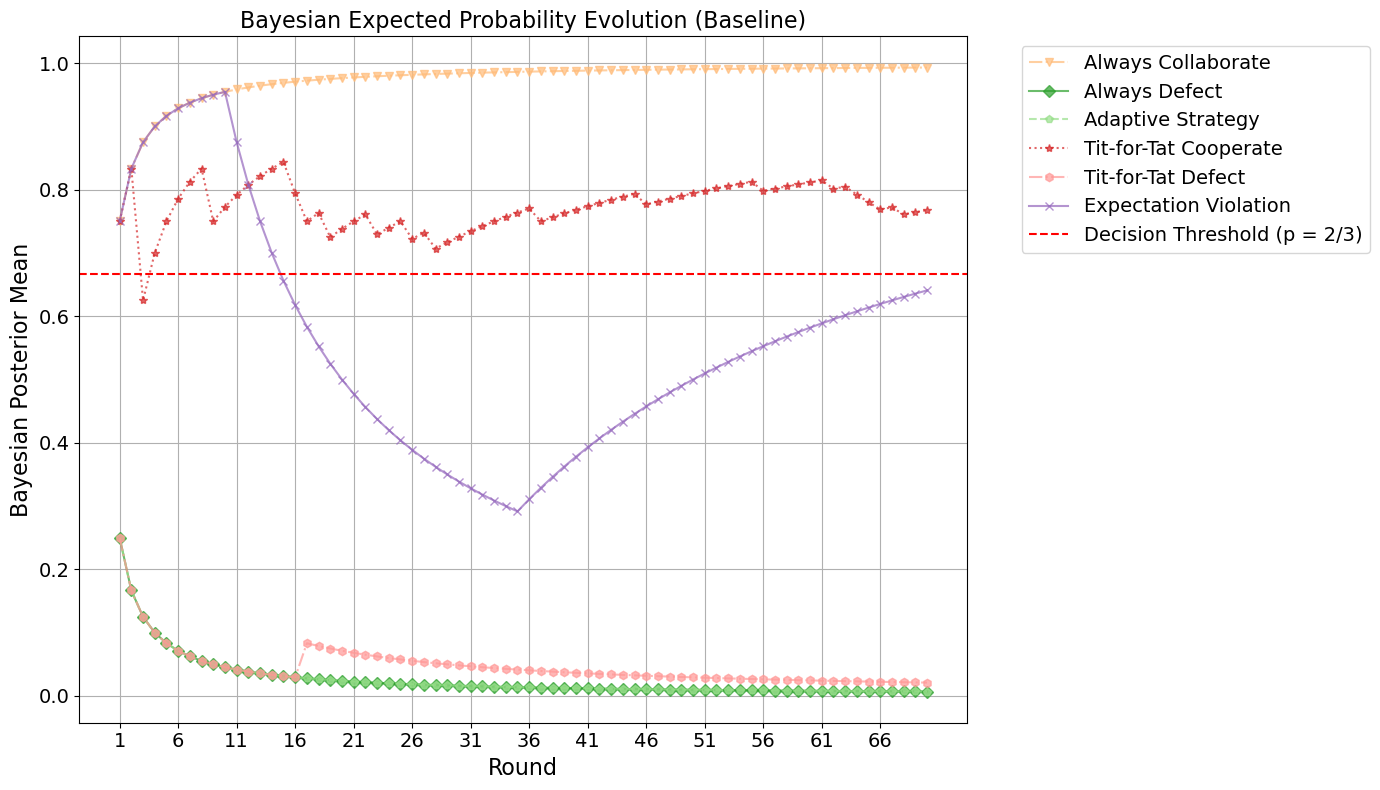

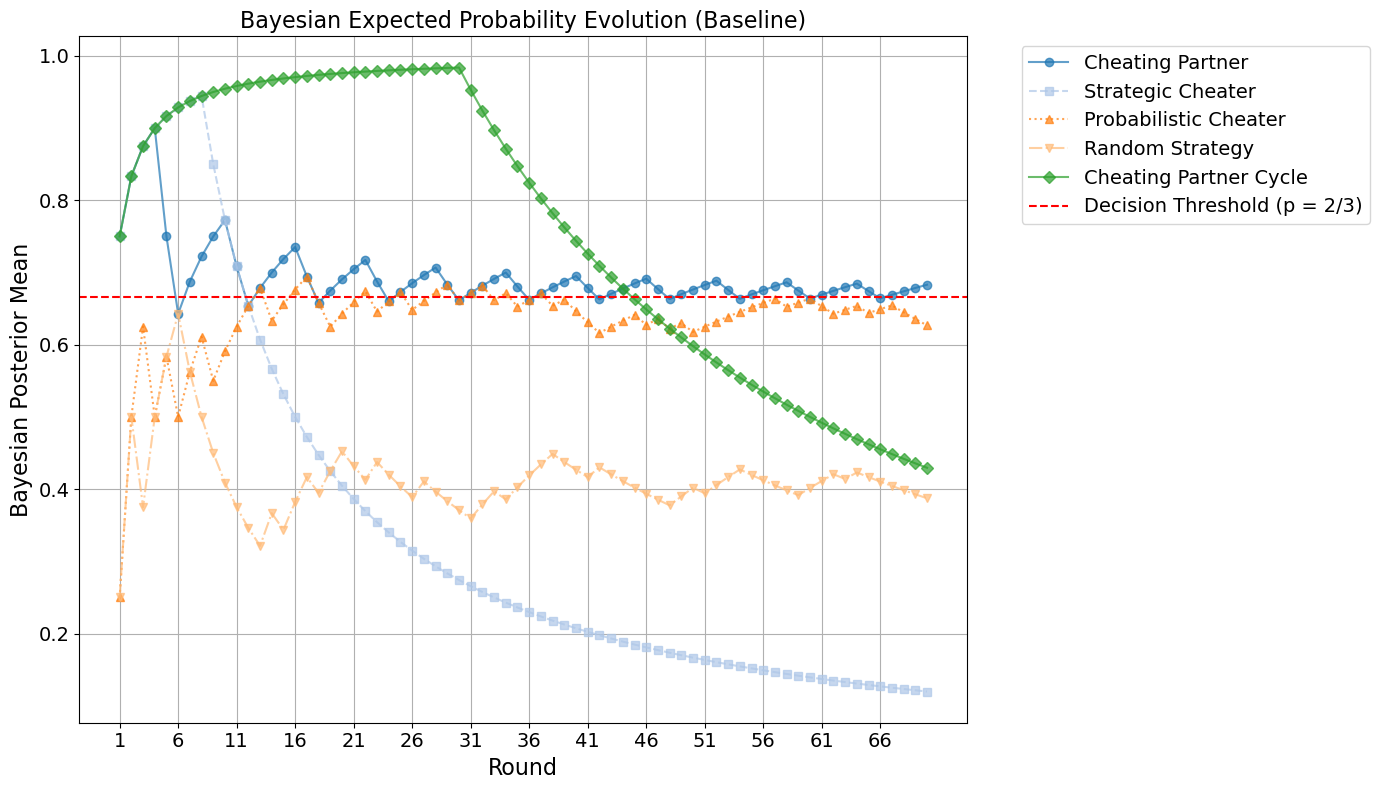

In [11]:
# ---------- Expected Probability (Beysian Agent) Evolution: cooperative-ish set ----------
import seaborn as sns

# Define plotting styles
colors = sns.color_palette("tab20", 10)  #
line_styles = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'x', '+']

# Strategies 1: cooperative-ish set
strategies_focal_1 = [
    ("Always Collaborate", df_bayes_collab ),
    ("Always Defect", df_bayes_defect ),
    ("Adaptive Strategy", df_bayes_adaptive),
    ("Tit-for-Tat Cooperate", df_bayes_tft_c),
    ("Tit-for-Tat Defect", df_bayes_tft_d),
    ("Expectation Violation", df_bayes_expect)
]

plt.figure(figsize=(14, 8))
for idx, (name, df) in enumerate(strategies_focal_1):
    plt.plot(df["Round"], df["Posterior_Mean"], label=name,
             color=colors[idx+3], linestyle=line_styles[idx+3], marker=markers[idx+3], alpha=0.7)

plt.axhline(2/3, color='red', linestyle='--', label='Decision Threshold (p = 2/3)')
plt.xlabel("Round", fontsize=16)
plt.ylabel("Bayesian Posterior Mean", fontsize=16)
plt.title("Bayesian Expected Probability Evolution (Baseline)", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# ---------- Expected Probability (Beysian Agent) Evolution
strategies_focal_2 = [
    ("Cheating Partner", df_bayes_cheating),
    ("Strategic Cheater", df_bayes_strat),
    ("Probabilistic Cheater", df_bayes_prob),
    ("Random Strategy", df_bayes_random),
    ("Cheating Partner Cycle", df_bayes_cheating_partner_cycle)
]

plt.figure(figsize=(14, 8))
for idx, (name, df) in enumerate(strategies_focal_2):
    plt.plot(df["Round"], df["Posterior_Mean"], label=name,
             color=colors[idx], linestyle=line_styles[idx], marker=markers[idx], alpha=0.7)

plt.axhline(2/3, color='red', linestyle='--', label='Decision Threshold (p = 2/3)')
plt.xlabel("Round", fontsize=16)
plt.ylabel("Bayesian Posterior Mean", fontsize=16)
plt.title("Bayesian Expected Probability Evolution (Baseline)", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [12]:
df_bayes_strat

,Round,Agent_Choice,Partner_Choice,Posterior_Mean,Alpha,Beta,Concentration
0,1,0,1,0.750000,1.5,0.5,1.0
1,2,1,1,0.833333,2.5,0.5,2.0
2,3,1,1,0.875000,3.5,0.5,3.0
3,4,1,1,0.900000,4.5,0.5,4.0
4,5,1,1,0.916667,5.5,0.5,5.0
...,...,...,...,...,...,...,...
65,66,0,0,0.126866,8.5,58.5,66.0
66,67,0,0,0.125000,8.5,59.5,67.0
67,68,0,0,0.123188,8.5,60.5,68.0
68,69,0,0,0.121429,8.5,61.5,69.0


In [13]:
df_bayes_tft_c.tail()

,Round,Agent_Choice,Partner_Choice,Posterior_Mean,Alpha,Beta,Concentration
65,66,1,0,0.768657,51.5,15.5,66.0
66,67,0,1,0.772059,52.5,15.5,67.0
67,68,1,0,0.760870,52.5,16.5,68.0
68,69,1,1,0.764286,53.5,16.5,69.0
69,70,0,1,0.767606,54.5,16.5,70.0


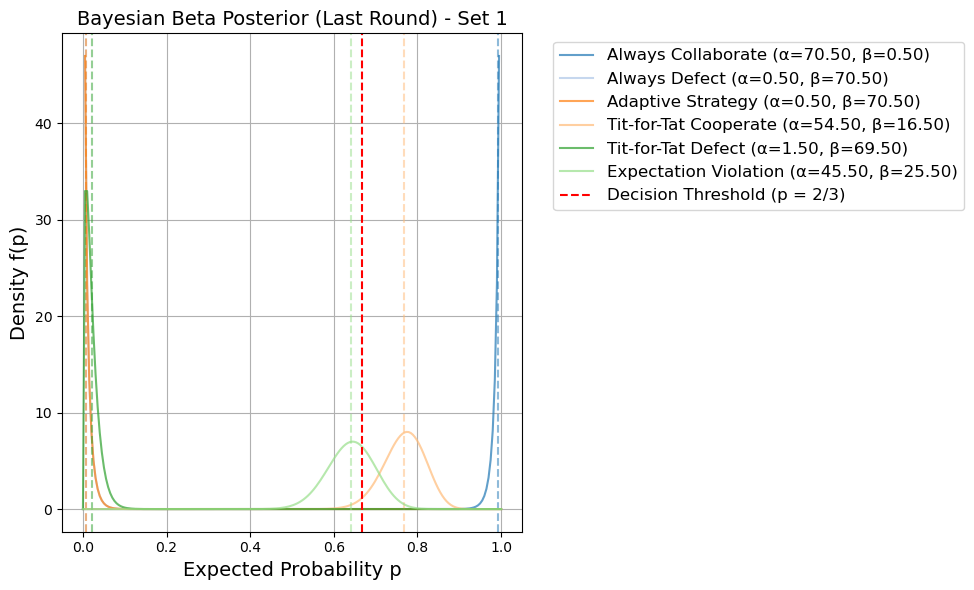

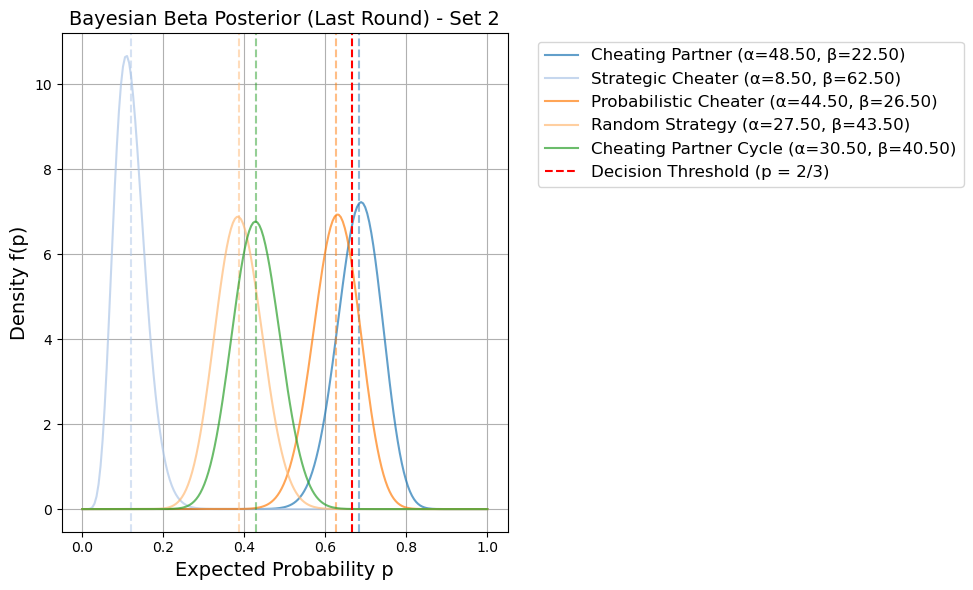

In [14]:
from scipy import stats

# Pick the same sets you used earlier
strategies_bayes_1 = [
    ("Always Collaborate", df_bayes_collab),
    ("Always Defect", df_bayes_defect),
    ("Adaptive Strategy", df_bayes_adaptive),
    ("Tit-for-Tat Cooperate", df_bayes_tft_c),
    ("Tit-for-Tat Defect", df_bayes_tft_d),
    ("Expectation Violation", df_bayes_expect)
]

# --- Plot Beta PDFs for set 1 ---
p = np.linspace(0, 1, 200)
plt.figure(figsize=(10, 6))
colors = sns.color_palette("tab20", 10)

for idx, (name, dfb) in enumerate(strategies_bayes_1):
    last = dfb.iloc[-1]
    alpha, beta = last["Alpha"], last["Beta"]
    # Posterior mean (vertical line)
    E_p = last["Posterior_Mean"]
    plt.plot(p, stats.beta.pdf(p, alpha, beta),
             label=f"{name} (α={alpha:.2f}, β={beta:.2f})",
             alpha=0.7, color=colors[idx])
    plt.axvline(x=E_p, linestyle='--', alpha=0.5, color=colors[idx])

plt.axvline(x=2/3, color='red', linestyle='--', label='Decision Threshold (p = 2/3)')
plt.xlabel("Expected Probability p", fontsize=14)
plt.ylabel("Density f(p)", fontsize=14)
plt.title("Bayesian Beta Posterior (Last Round) - Set 1", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# --- Plot Beta PDFs for set 2 (adversarial/noisy) ---
strategies_bayes_2 = [
    ("Cheating Partner", df_bayes_cheating),
    ("Strategic Cheater", df_bayes_strat),
    ("Probabilistic Cheater", df_bayes_prob),
    ("Random Strategy", df_bayes_random),
    ("Cheating Partner Cycle", df_bayes_cheating_partner_cycle)
]

plt.figure(figsize=(10, 6))
for idx, (name, dfb) in enumerate(strategies_bayes_2):
    last = dfb.iloc[-1]
    alpha, beta = last["Alpha"], last["Beta"]
    E_p = last["Posterior_Mean"]
    plt.plot(p, stats.beta.pdf(p, alpha, beta),
             label=f"{name} (α={alpha:.2f}, β={beta:.2f})",
             alpha=0.7, color=colors[idx])
    plt.axvline(x=E_p, linestyle='--', alpha=0.5, color=colors[idx])

plt.axvline(x=2/3, color='red', linestyle='--', label='Decision Threshold (p = 2/3)')
plt.xlabel("Expected Probability p", fontsize=14)
plt.ylabel("Density f(p)", fontsize=14)
plt.title("Bayesian Beta Posterior (Last Round) - Set 2", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()


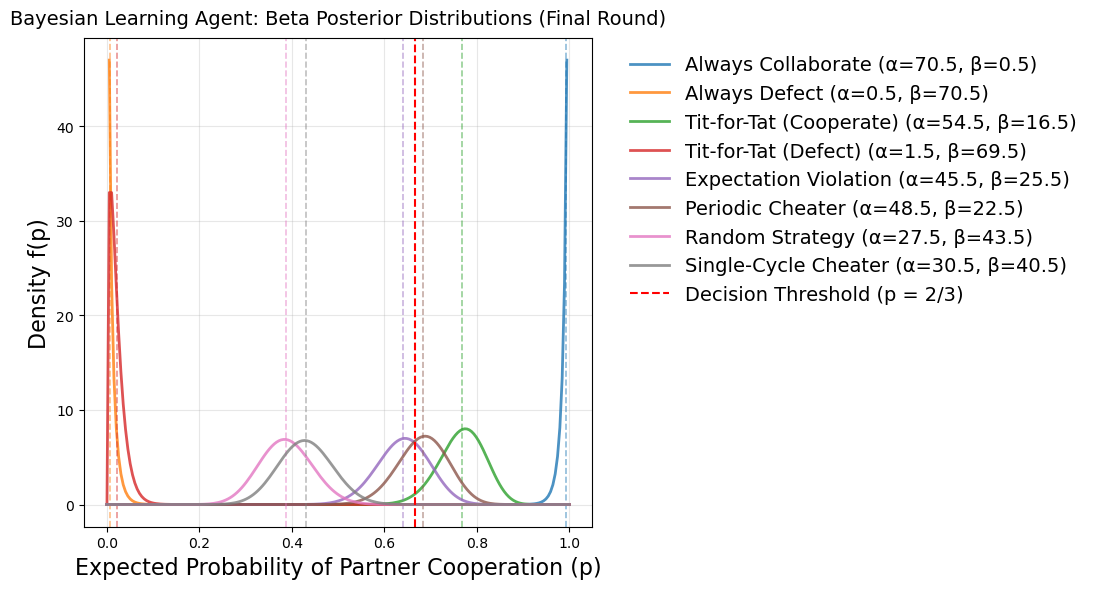

In [15]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Combined selected partners (8 total) ---
strategies_bayes = [
    ("Always Collaborate", df_bayes_collab),
    ("Always Defect", df_bayes_defect),
    ("Tit-for-Tat (Cooperate)", df_bayes_tft_c),
    ("Tit-for-Tat (Defect)", df_bayes_tft_d),
    ("Expectation Violation", df_bayes_expect),
    ("Periodic Cheater", df_bayes_cheating),
    ("Random Strategy", df_bayes_random),
    ("Single-Cycle Cheater", df_bayes_cheating_partner_cycle)
]

# --- Plot Beta PDFs for all selected partners ---
p = np.linspace(0, 1, 200)
plt.figure(figsize=(11, 6))
colors = sns.color_palette("tab10", len(strategies_bayes))

for idx, (name, dfb) in enumerate(strategies_bayes):
    last = dfb.iloc[-1]
    alpha, beta = last["Alpha"], last["Beta"]
    E_p = last["Posterior_Mean"]

    # Plot the Beta PDF
    plt.plot(p, stats.beta.pdf(p, alpha, beta),
             label=f"{name} (α={alpha:.1f}, β={beta:.1f})",
             linewidth=2, alpha=0.8, color=colors[idx])
    
    # Vertical line for posterior mean
    plt.axvline(x=E_p, linestyle='--', linewidth=1.2, alpha=0.5, color=colors[idx])

# --- Decision threshold ---
plt.axvline(x=2/3, color='red', linestyle='--', linewidth=1.5, label='Decision Threshold (p = 2/3)')

# --- Formatting ---
plt.xlabel("Expected Probability of Partner Cooperation (p)", fontsize=16)
plt.ylabel("Density f(p)", fontsize=16)
plt.title("Bayesian Learning Agent: Beta Posterior Distributions (Final Round)", fontsize=14, pad=10)
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', fontsize=14, frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

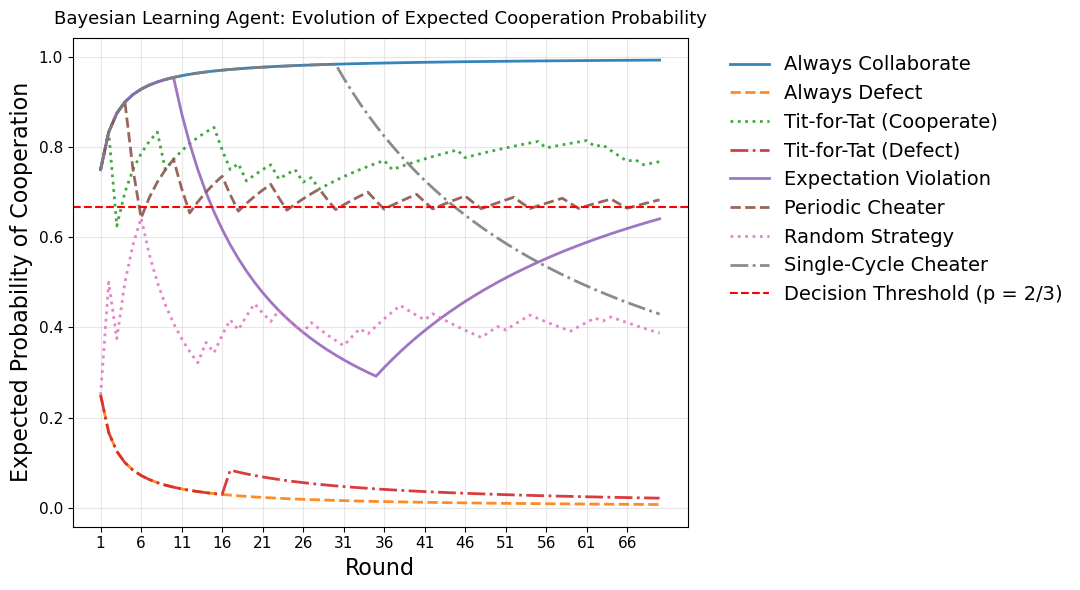

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Selected 8 partner strategies ---
strategies_bayes = [
    ("Always Collaborate", df_bayes_collab),
    ("Always Defect", df_bayes_defect),
    ("Tit-for-Tat (Cooperate)", df_bayes_tft_c),
    ("Tit-for-Tat (Defect)", df_bayes_tft_d),
    ("Expectation Violation", df_bayes_expect),
    ("Periodic Cheater", df_bayes_cheating),
    ("Random Strategy", df_bayes_random),
    ("Single-Cycle Cheater", df_bayes_cheating_partner_cycle)
]

# --- Plot setup ---
plt.figure(figsize=(11, 6))
colors = sns.color_palette("tab10", len(strategies_bayes))
line_styles = ['-', '--', ':', '-.', '-', '--', ':', '-.']

# --- Plot Bayesian posterior mean evolution for all partners ---
for idx, (name, df) in enumerate(strategies_bayes):
    plt.plot(df["Round"], df["Posterior_Mean"],
             label=name,
             color=colors[idx],
             linestyle=line_styles[idx % len(line_styles)],
             linewidth=2,
             alpha=0.9)

# --- Decision threshold ---
plt.axhline(2/3, color='red', linestyle='--', linewidth=1.5,
            label='Decision Threshold (p = 2/3)')

# --- Formatting ---
plt.xlabel("Round", fontsize=16)
plt.ylabel("Expected Probability of Cooperation", fontsize=16)
plt.title("Bayesian Learning Agent: Evolution of Expected Cooperation Probability", fontsize=13, pad=10)
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', fontsize=14, frameon=False)
plt.grid(alpha=0.3)
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


In [17]:
print("Bayesian - Decision-Making Trends in the Last Round:")
for name, dfb in strategies_bayes_1:
    last = dfb.iloc[-1]
    last_choice = last["Agent_Choice"]
    last_p = last["Posterior_Mean"]
    print(f"{name}: p = {last_p:.3f}, Choice = {'Stag' if last_choice == 1 else 'Hare'}")

for name, dfb in strategies_bayes_2:
    last = dfb.iloc[-1]
    last_choice = last["Agent_Choice"]
    last_p = last["Posterior_Mean"]
    print(f"{name}: p = {last_p:.3f}, Choice = {'Stag' if last_choice == 1 else 'Hare'}")


Bayesian - Decision-Making Trends in the Last Round:
Always Collaborate: p = 0.993, Choice = Stag
Always Defect: p = 0.007, Choice = Hare
Adaptive Strategy: p = 0.007, Choice = Hare
Tit-for-Tat Cooperate: p = 0.768, Choice = Hare
Tit-for-Tat Defect: p = 0.021, Choice = Hare
Expectation Violation: p = 0.641, Choice = Hare
Cheating Partner: p = 0.683, Choice = Stag
Strategic Cheater: p = 0.120, Choice = Hare
Probabilistic Cheater: p = 0.627, Choice = Hare
Random Strategy: p = 0.387, Choice = Hare
Cheating Partner Cycle: p = 0.430, Choice = Hare


In [18]:
def add_payoffs(df):
    df = df.copy()
    p1 = df["Agent_Choice"].astype(int).to_numpy()
    p2 = df["Partner_Choice"].astype(int).to_numpy()
    df["Agent_Payoff"] = payoff[p1, p2, 0]
    df["Partner_Payoff"] = payoff[p1, p2, 1]
    return df

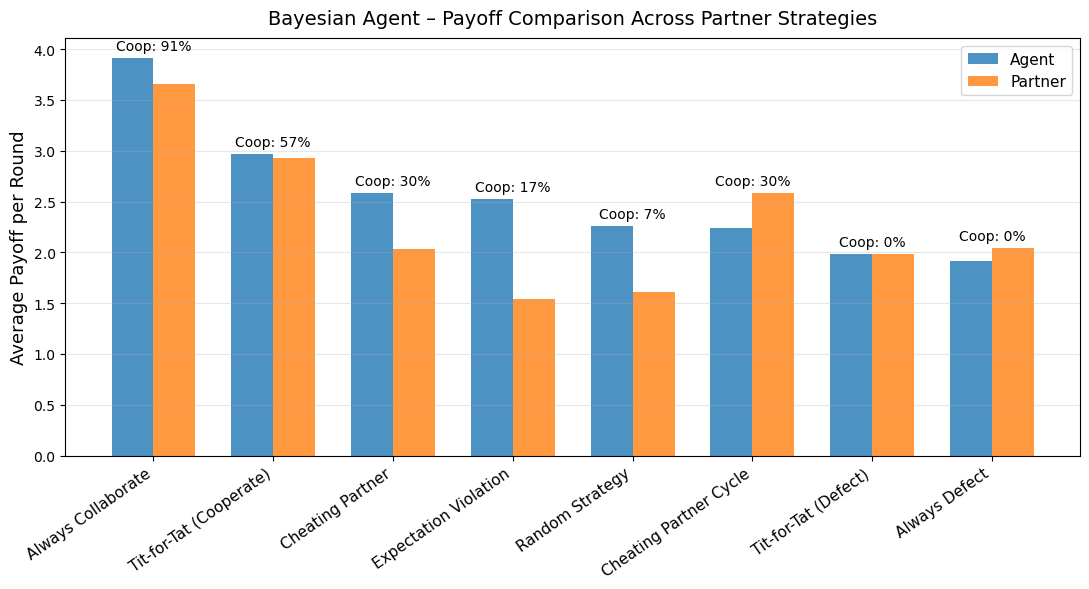


Detailed Strategy Analysis (Bayesian Agent):
               Strategy  Total Agent Payoff  Total Partner Payoff  Avg Agent Payoff  Avg Partner Payoff  Mutual Cooperation Rate
     Always Collaborate                 274                   256              3.91                3.66                     0.91
Tit-for-Tat (Cooperate)                 208                   205              2.97                2.93                     0.57
       Cheating Partner                 181                   142              2.59                2.03                     0.30
  Expectation Violation                 177                   108              2.53                1.54                     0.17
        Random Strategy                 158                   113              2.26                1.61                     0.07
 Cheating Partner Cycle                 157                   181              2.24                2.59                     0.30
   Tit-for-Tat (Defect)                 139        

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_payoffs(strategy_name: str, df: pd.DataFrame) -> dict:
    """Compute payoff metrics for a given strategy."""
    df_with_payoff = add_payoffs(df)
    return {
        'Strategy': strategy_name,
        'Total Agent Payoff': df_with_payoff['Agent_Payoff'].sum(),
        'Total Partner Payoff': df_with_payoff['Partner_Payoff'].sum(),
        'Avg Agent Payoff': df_with_payoff['Agent_Payoff'].mean(),
        'Avg Partner Payoff': df_with_payoff['Partner_Payoff'].mean(),
        'Mutual Cooperation Rate': (df_with_payoff['Agent_Choice'] & df_with_payoff['Partner_Choice']).mean()
    }

# --- Analyze selected 8 strategies for Bayesian agent ---
strategy_results_bayes = pd.DataFrame([
    analyze_payoffs("Always Collaborate", df_bayes_collab),
    analyze_payoffs("Always Defect", df_bayes_defect),
    analyze_payoffs("Tit-for-Tat (Cooperate)", df_bayes_tft_c),
    analyze_payoffs("Tit-for-Tat (Defect)", df_bayes_tft_d),
    analyze_payoffs("Expectation Violation", df_bayes_expect),
    analyze_payoffs("Cheating Partner", df_bayes_cheating),
    analyze_payoffs("Random Strategy", df_bayes_random),
    analyze_payoffs("Cheating Partner Cycle", df_bayes_cheating_partner_cycle)
])

# --- Sort by total agent payoff ---
strategy_results_bayes = strategy_results_bayes.sort_values('Total Agent Payoff', ascending=False)

# --- Visualization ---
plt.figure(figsize=(11, 6))
x = np.arange(len(strategy_results_bayes))
width = 0.35
colors = sns.color_palette("tab10", len(strategy_results_bayes))

# Bars for average payoffs
plt.bar(x - width/2, strategy_results_bayes['Avg Agent Payoff'], width,
        label='Agent', color=colors[0], alpha=0.8)
plt.bar(x + width/2, strategy_results_bayes['Avg Partner Payoff'], width,
        label='Partner', color=colors[1], alpha=0.8)

# Axis labels and title
plt.ylabel('Average Payoff per Round', fontsize=13)
plt.title('Bayesian Agent – Payoff Comparison Across Partner Strategies', fontsize=14, pad=10)
plt.xticks(x, strategy_results_bayes['Strategy'], rotation=35, ha='right', fontsize=11)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)

# Add cooperation rates as annotations
for i, row in enumerate(strategy_results_bayes.itertuples()):
    plt.text(i, max(row._4, row._5) + 0.05, 
             f'Coop: {row._6:.0%}', 
             ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

# --- Optional: print summary ---
print("\nDetailed Strategy Analysis (Bayesian Agent):")
print(strategy_results_bayes.round(2).to_string(index=False))


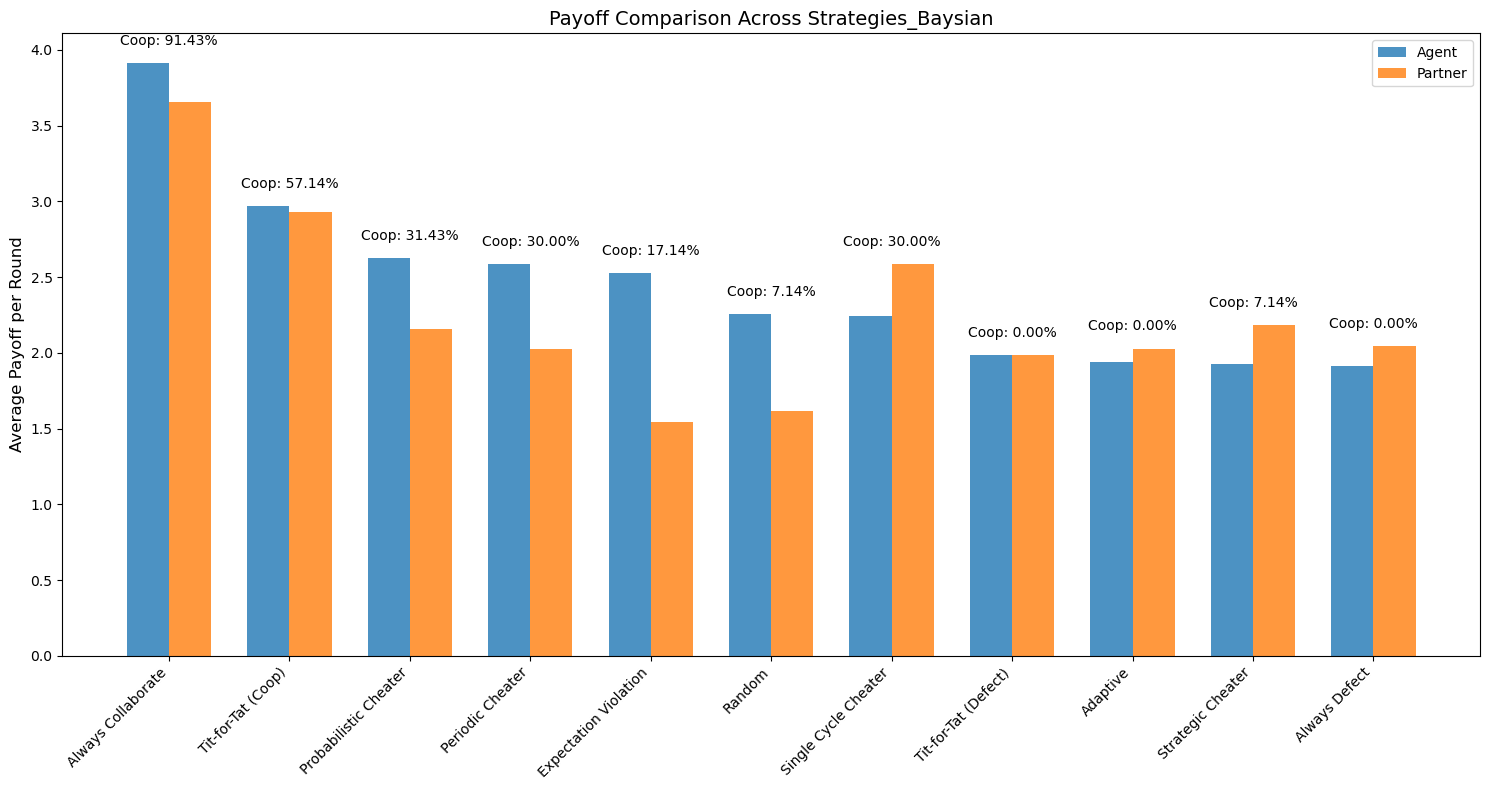


Detailed Strategy Analysis:
             Strategy  Total Agent Payoff  Total Partner Payoff  Avg Agent Payoff  Avg Partner Payoff  Mutual Cooperation Rate
   Always Collaborate                 274                   256              3.91                3.66                     0.91
   Tit-for-Tat (Coop)                 208                   205              2.97                2.93                     0.57
Probabilistic Cheater                 184                   151              2.63                2.16                     0.31
     Periodic Cheater                 181                   142              2.59                2.03                     0.30
Expectation Violation                 177                   108              2.53                1.54                     0.17
               Random                 158                   113              2.26                1.61                     0.07
 Single Cycle Cheater                 157                   181              2.24 

In [20]:
def analyze_payoffs(strategy_name: str, df: pd.DataFrame) -> dict:
    """Analyze payoffs for a given strategy."""
    df_with_payoff = add_payoffs(df)
    return {
        'Strategy': strategy_name,
        'Total Agent Payoff': df_with_payoff['Agent_Payoff'].sum(),
        'Total Partner Payoff': df_with_payoff['Partner_Payoff'].sum(),
        'Avg Agent Payoff': df_with_payoff['Agent_Payoff'].mean(),
        'Avg Partner Payoff': df_with_payoff['Partner_Payoff'].mean(),
        'Mutual Cooperation Rate': (df_with_payoff['Agent_Choice'] & df_with_payoff['Partner_Choice']).mean()
    }

# Analyze all strategies
strategy_results = pd.DataFrame([
    analyze_payoffs("Tit-for-Tat (Coop)", df_bayes_tft_c),
    analyze_payoffs("Tit-for-Tat (Defect)", df_bayes_tft_d),
    analyze_payoffs("Expectation Violation", df_bayes_expect),
    analyze_payoffs("Periodic Cheater", df_bayes_cheating),
    analyze_payoffs("Single Cycle Cheater", df_bayes_cheating_partner_cycle),
    analyze_payoffs("Probabilistic Cheater", df_bayes_prob),
    analyze_payoffs("Strategic Cheater", df_bayes_strat),
    analyze_payoffs("Always Collaborate", df_bayes_collab),
    analyze_payoffs("Always Defect", df_bayes_defect),
    analyze_payoffs("Random", df_bayes_random),
    analyze_payoffs("Adaptive", df_bayes_adaptive)
])

# Sort by total agent payoff to see most successful strategies
strategy_results = strategy_results.sort_values('Total Agent Payoff', ascending=False)

# Create visualization
plt.figure(figsize=(15, 8))
x = np.arange(len(strategy_results))
width = 0.35

plt.bar(x - width/2, strategy_results['Avg Agent Payoff'], width, label='Agent', alpha=0.8)
plt.bar(x + width/2, strategy_results['Avg Partner Payoff'], width, label='Partner', alpha=0.8)

plt.ylabel('Average Payoff per Round', fontsize=12)
plt.title('Payoff Comparison Across Strategies_Baysian', fontsize=14)
plt.xticks(x, strategy_results['Strategy'], rotation=45, ha='right')
plt.legend()

# Add cooperation rate as text on top of bars
for i, row in enumerate(strategy_results.itertuples()):
    plt.text(i, max(row._4, row._5) + 0.1, 
             f'Coop: {row._6:.2%}', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Strategy Analysis:")
print(strategy_results.round(2).to_string(index=False))

In [21]:
df_bayes_tft_c

,Round,Agent_Choice,Partner_Choice,Posterior_Mean,Alpha,Beta,Concentration
0,1,1,1,0.750000,1.5,0.5,1.0
1,2,0,1,0.833333,2.5,0.5,2.0
2,3,1,0,0.625000,2.5,1.5,3.0
3,4,1,1,0.700000,3.5,1.5,4.0
4,5,1,1,0.750000,4.5,1.5,5.0
...,...,...,...,...,...,...,...
65,66,1,0,0.768657,51.5,15.5,66.0
66,67,0,1,0.772059,52.5,15.5,67.0
67,68,1,0,0.760870,52.5,16.5,68.0
68,69,1,1,0.764286,53.5,16.5,69.0


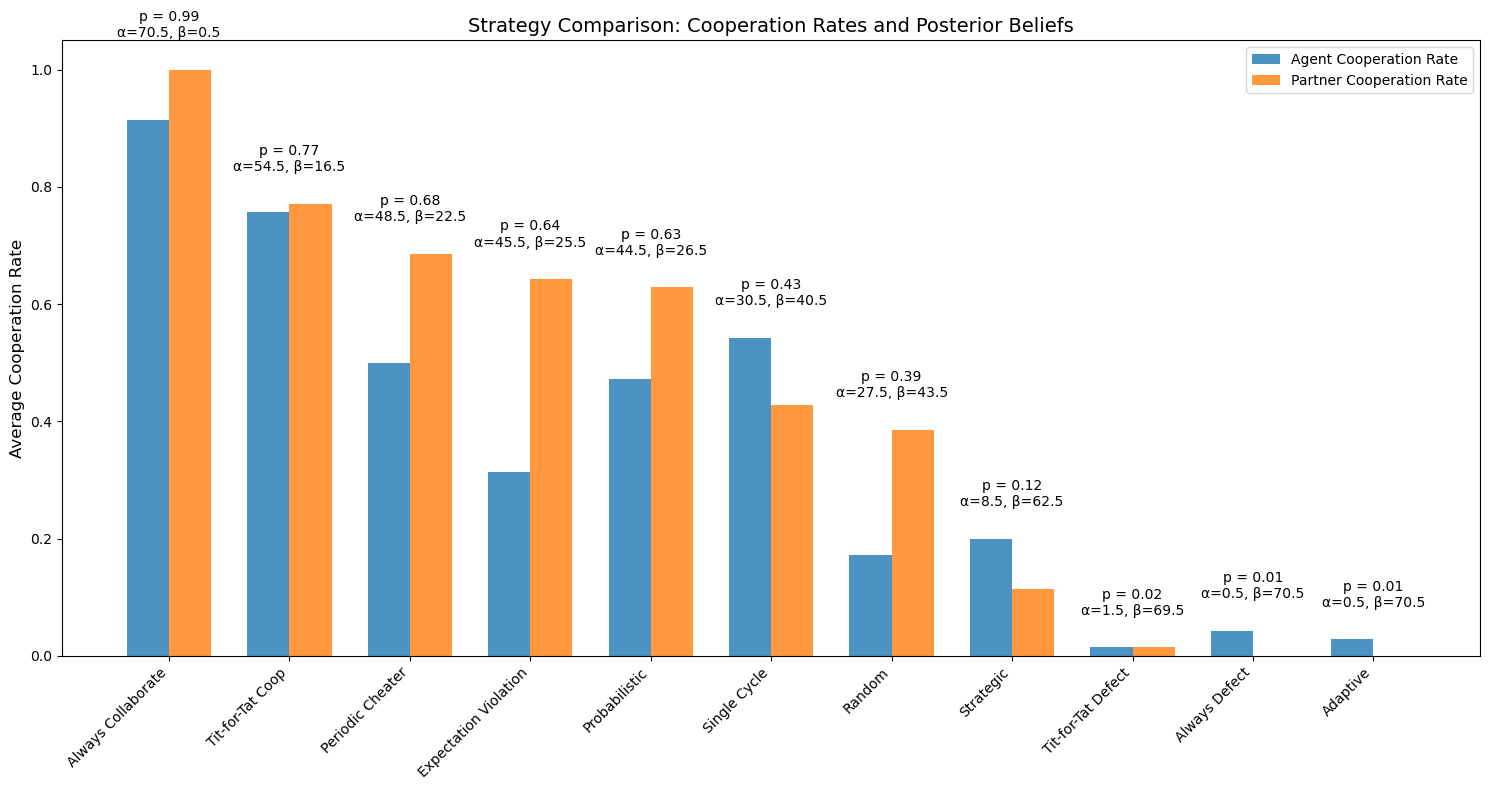


Detailed Bayesian Analysis:
             Strategy  Final Alpha  Final Beta  Final Posterior Mean  Final Concentration  Mutual Cooperation Rate  Agent Cooperation Rate  Partner Cooperation Rate
   Always Collaborate         70.5         0.5                 0.993                 70.0                    0.914                   0.914                     1.000
     Tit-for-Tat Coop         54.5        16.5                 0.768                 70.0                    0.571                   0.757                     0.771
     Periodic Cheater         48.5        22.5                 0.683                 70.0                    0.300                   0.500                     0.686
Expectation Violation         45.5        25.5                 0.641                 70.0                    0.171                   0.314                     0.643
        Probabilistic         44.5        26.5                 0.627                 70.0                    0.314                   0.471        

In [22]:
def analyze_bayesian_results(strategy_name: str, df: pd.DataFrame) -> dict:
    """Analyze results for a given strategy with Bayesian agent."""
    return {
        'Strategy': strategy_name,
        'Final Alpha': df['Alpha'].iloc[-1],
        'Final Beta': df['Beta'].iloc[-1],
        'Final Posterior Mean': df['Posterior_Mean'].iloc[-1],
        'Final Concentration': df['Concentration'].iloc[-1],
        'Mutual Cooperation Rate': (df['Agent_Choice'] & df['Partner_Choice']).mean(),
        'Agent Cooperation Rate': df['Agent_Choice'].mean(),
        'Partner Cooperation Rate': df['Partner_Choice'].mean()
    }

# Analyze all strategies
strategy_results = pd.DataFrame([
    analyze_bayesian_results("Always Collaborate", df_bayes_collab),
    analyze_bayesian_results("Always Defect", df_bayes_defect),
    analyze_bayesian_results("Random", df_bayes_random),
    analyze_bayesian_results("Probabilistic", df_bayes_prob),
    analyze_bayesian_results("Periodic Cheater", df_bayes_cheating),
    analyze_bayesian_results("Single Cycle", df_bayes_cheating_partner_cycle),
    analyze_bayesian_results("Tit-for-Tat Coop", df_bayes_tft_c),
    analyze_bayesian_results("Tit-for-Tat Defect", df_bayes_tft_d),
    analyze_bayesian_results("Adaptive", df_bayes_adaptive),
    analyze_bayesian_results("Strategic", df_bayes_strat),
    analyze_bayesian_results("Expectation Violation", df_bayes_expect)
])

# Sort by posterior mean to see most "trusted" strategies
strategy_results = strategy_results.sort_values('Final Posterior Mean', ascending=False)

# Create visualization
plt.figure(figsize=(15, 8))
x = np.arange(len(strategy_results))
width = 0.35

plt.bar(x - width/2, strategy_results['Agent Cooperation Rate'], width, 
       label='Agent Cooperation Rate', alpha=0.8)
plt.bar(x + width/2, strategy_results['Partner Cooperation Rate'], width,
       label='Partner Cooperation Rate', alpha=0.8)

plt.ylabel('Average Cooperation Rate', fontsize=12)
plt.title('Strategy Comparison: Cooperation Rates and Posterior Beliefs', fontsize=14)
plt.xticks(x, strategy_results['Strategy'], rotation=45, ha='right')
plt.legend()

# Add posterior mean as text on top of bars
for i, row in enumerate(strategy_results.itertuples()):
    plt.text(i, max(row._7, row._8) + 0.05,  # Using index positions since column names changed
             f'p = {row._4:.2f}\nα={row._2:.1f}, β={row._3:.1f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Bayesian Analysis:")
print(strategy_results.round(3).to_string(index=False))